# **Description:**


---


---


**Filename**: EEA_Hurricanes_15(Final)_[GEV_Models] \\
**Version**: 15 (Final)

---


**Key Points/Updates**:

*   Implementing joint constraint reparameterization with upper bound and lower bound on $\xi$
* Estimating  $\mu, \sigma, \xi $ (assuming local $\mu, \sigma, \xi $)
* Estimating $ \hat{y}, y_{q1}, y_{q2}$
* Baselines: FCN, LSTM
* Loss = $\lambda_1*\text{GEV_Loss}(y, \mu, \sigma, \xi_p, \xi_n) + (1-\lambda_1)*RMSE(y, \hat{y}) $
  * GEV_Loss = $\lambda_2*NLL(y, \mu, \sigma, \xi_p) + (1-\lambda_2)*RMSE(\xi_p, \xi_n) $
  * $ \hat{y} =$ output from model
* GEV parameters estimation analysis









---



---






In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import os, random
import math
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import rc, style
import seaborn as sns
import datetime as dt
from tqdm import tqdm as tq
from numpy import vstack, sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
import matplotlib.patches as mpatches
from google.colab import files
from statistics import mean
import scipy.stats as stats
from scipy.special import gamma

from scipy.stats import genextreme
from scipy.stats import pearsonr

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

from functools import partial
from pylab import rcParams

import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary

# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler
# from ray.tune.stopper import TrialPlateauStopper

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.8)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 24, 10
register_matplotlib_converters()

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING=1
torch.use_deterministic_algorithms(False)

**Data Loading**

In [6]:
data_path = '/content/drive/MyDrive/DeepExtremaData/'

In [7]:
hurricanefile_nhc = data_path+'hurricane.mat'
hurricane_data_nhc = scipy.io.loadmat(hurricanefile_nhc)
hurricane_nhc = hurricane_data_nhc['hurricane']
hurricanefile = data_path+'hurricane_1.mat'
hurricane_data = scipy.io.loadmat(hurricanefile)
hurricane = hurricane_data['hurricane']
forecasts_data_file = data_path+'forecasts_int.mat'
forecasts_data_mat = scipy.io.loadmat(forecasts_data_file)
nhc_forecasts = forecasts_data_mat['NHC']
time_split = forecasts_data_mat['time']
model_forecasts = forecasts_data_mat['X']
ground_truths = forecasts_data_mat['Y']
best_track_file = data_path+'best_track.mat'
best_track_matlab_data = scipy.io.loadmat(best_track_file)
best_track = best_track_matlab_data['best_track']

**General Hyperparameters**

In [8]:
train_test_ratio = 0.8
batch_size = 128

**General Functions**

In [9]:
def calculate_nll(block_maxima, mu, sigma, xi, name="Test", is_return = False):
  size =  block_maxima.shape[0]
  block_maxima = torch.flatten(block_maxima.cpu())
  if not torch.is_tensor(mu):
      mu = torch.from_numpy(mu).float().to(device)
  if not torch.is_tensor(sigma):
      sigma = torch.from_numpy(sigma).float().to(device)
  if not torch.is_tensor(xi):
      xi = torch.from_numpy(xi).float().to(device)
  if mu.numel() == 1:
      mu = torch.flatten(torch.full((size,1), mu))
  if sigma.numel() == 1:
      sigma = torch.flatten(torch.full((size,1), sigma))
  if xi.numel() == 1:
      xi = torch.full((size,1), xi)
  mu = torch.flatten(mu).cpu()
  sigma = torch.flatten(sigma).cpu()
  xi = torch.flatten(xi).cpu()

  #using library
  log_pdf = genextreme.logpdf(block_maxima, loc = mu.detach().numpy(), scale = sigma.detach().numpy(), c = -xi.detach().numpy())
  log_likelihood = np.sum(log_pdf)
  #using vector
  # print(xi.shape, block_maxima.shape, mu.shape, sigma.shape)
  constraint = 1+(xi/sigma)*(block_maxima-mu)
  # constraint = constraint[constraint>0]
  constraint[constraint<0.05] = torch.tensor(0.5)
  first_term = torch.sum(torch.log(sigma))
  second_term =  (torch.sum((1+1/xi)*torch.log(constraint)))
  third_term =  torch.sum(constraint**(-1/xi))
  nll = (first_term + second_term + third_term)
  if is_return:
      return nll
  else:
      print("\n"+name+": \n")
      print("negative log likelihood using library:", -log_likelihood, " and using vector:", nll.item())
      print(f"first_term: {first_term}, second_term: {second_term}, third_term: {third_term}")

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

def plot_histogram(data, plot_name="Test"):
  data = np.array(data.cpu())
  plt.figure(figsize=(10,5))
  plt.hist(data, bins = 55)
  title = "Histogram of " +plot_name
  plt.title(title)
  plt.show()

def inverse_scaler(predictions, actuals):
    predictions_inverse_scaler = scaler.inverse_transform(predictions)
    actuals_inverse_scaler = scaler.inverse_transform(actuals)
    return predictions_inverse_scaler, actuals_inverse_scaler

**Data Creation**

In [10]:
total_timesteps= 24
train_time_steps = 16
test_time_steps = total_timesteps - train_time_steps
number_of_hurricanes = best_track[0].shape[0]
number_of_hurricanes

3111

In [11]:
nhc_hurricane_forecast_dict = {}
nhc_original_dict = {}
test_data_raw = []
valid_nhc_forecasts = 0
for i in range(time_split.shape[0]):
  nhc_hurricane_timesteps = time_split[i][1] - time_split[i][0] + 1
  if  nhc_hurricane_timesteps >= total_timesteps:
    first_point_index = time_split[i][0] - 1
    prediction_window_start = first_point_index + train_time_steps - 1
    nhc_forecast = nhc_forecasts[0,1:,prediction_window_start]
    hurricane_name = hurricane_nhc[0][i][0][0]
    if np.nansum(nhc_forecast) > 0:
      nhc_hurricane_forecast_dict[hurricane_name] = nhc_forecast
      nhc_original_dict[hurricane_name] = nhc_forecasts[0,0,prediction_window_start+1:prediction_window_start+test_time_steps+1]
      test_data_raw.append(nhc_forecasts[0,0,first_point_index:first_point_index+total_timesteps])
      valid_nhc_forecasts +=1
    prediction_window_index = prediction_window_start + test_time_steps
    j=1
    while prediction_window_index + test_time_steps < first_point_index+nhc_hurricane_timesteps:
      nhc_forecast = nhc_forecasts[0,1:,prediction_window_index]
      if np.nansum(nhc_forecast) > 0:
        key = hurricane_name+"_"+str(j+1)
        nhc_hurricane_forecast_dict[key] = nhc_forecast
        nhc_original_dict[key] = nhc_forecasts[0,0,prediction_window_index+1:prediction_window_index+test_time_steps+1]
        test_data_raw.append(nhc_forecasts[0,0,prediction_window_index+test_time_steps+1-total_timesteps:prediction_window_index+1+test_time_steps])
        j+=1
        valid_nhc_forecasts +=1
      prediction_window_index = prediction_window_index + test_time_steps

valid_nhc_forecasts
# nhc_hurricane_forecast_dict

212

In [12]:
total_observations = 0
hurricane_count = 0
for i in range(number_of_hurricanes):
    per_hurricane_observations = best_track[0][i].shape[0]
    if per_hurricane_observations>=total_timesteps:
        total_observations = total_observations + per_hurricane_observations - total_timesteps +1
        hurricane_count += 1
print("hurricane_count, total_observations:", hurricane_count, total_observations)

train_data = []
test_data = []
nhc_forecast_max = np.zeros(0)
hurricane_original_best_track= {}
nhc_count = 0
hurricane_serial=0
for i in range(number_of_hurricanes):
    per_hurricane_observations = best_track[0][i].shape[0]
    temp = []
    if per_hurricane_observations>=total_timesteps:
        for j in range(per_hurricane_observations):
            intensity = best_track[0][i][j][3]
            if j !=0:
              if intensity  < 0 : intensity = best_track[0][i][j-1][3]
            temp.append(intensity)
#             data[hurricane_serial,j]=intensity
        hurricane_serial+=1
    number_of_observations = len(temp)
    windows = 0
    neg_list = sum(n < 0 for n in temp)
    if neg_list>0: continue
    for k in range(0, number_of_observations+1-total_timesteps, test_time_steps):
        current_data = temp[k:k+total_timesteps]
        if k == 0:
          hurricane_key = hurricane[0][i][0][0]
        else: hurricane_key = hurricane[0][i][0][0]+"_"+str(windows+1)
        if hurricane_key in nhc_hurricane_forecast_dict:
            nhc_count  +=1
        else: train_data.append(current_data)
        windows +=1
print("Number of Hurricanes:", hurricane_serial)
print("Number of Hurricanes/Observations matched with NHC forecast:", nhc_count)
print("After moving window, number of train data:", len(train_data))

hurricane_count, total_observations: 1504 24384
Number of Hurricanes: 1504
Number of Hurricanes/Observations matched with NHC forecast: 212
After moving window, number of train data: 3525


**Train, Validate, Test Splits**

In [13]:
train_data = np.array(train_data)
test_data = np.array(test_data_raw)
print("Train and Test Data shape before normalizing/standardizing:", train_data.shape, test_data.shape)

# scaler=MinMaxcaler(feature_range=(0,1))
# train_data=scaler.fit_transform(train_data.reshape(-1,1))
#
scaler=StandardScaler()
train_data=scaler.fit_transform(train_data.reshape(-1,1))

train_data = train_data.reshape(-1,total_timesteps)
print("Train Data shape after normalizing/standardizing:", train_data.shape)

test_data=scaler.transform(test_data.reshape(-1,1))

test_data = test_data.reshape(-1,total_timesteps)
print("Train and Test Data shape before normalizing/standardizing:", train_data.shape, test_data.shape)

print("Before Validation Data: train vs test", train_data.shape, test_data.shape)

length = int(len(train_data)*0.8)
random.shuffle(train_data)
val_data= train_data[length:]
train_data = train_data[0:length]
print("After Validation Data (from train data): train vs validation vs test", train_data.shape, val_data.shape, test_data.shape)

Train and Test Data shape before normalizing/standardizing: (3525, 24) (212, 24)
Train Data shape after normalizing/standardizing: (3525, 24)
Train and Test Data shape before normalizing/standardizing: (3525, 24) (212, 24)
Before Validation Data: train vs test (3525, 24) (212, 24)
After Validation Data (from train data): train vs validation vs test (2820, 24) (705, 24) (212, 24)


**Data Preprocessing**

In [14]:
def extend_last_batch(X, y, batch_size=batch_size):
    last_batch_size = X.shape[0] % batch_size
    if last_batch_size != 0:
        indices = [i for i in range(0, (y.shape[0]-last_batch_size))]

        index = random.sample(indices, batch_size - last_batch_size)
        X_extended = X[index]
        y_extended = y[index]
        X = torch.cat((X, X_extended), 0)
        y = torch.cat((y, y_extended), 0)
    return X, y
def create_X_data(dataset, time_step=1):
    dataX = []
    for i in range(len(dataset)):
        X_data = dataset[i][0:time_step]
        dataX.append(X_data)
    return np.array(dataX)

def ready_X_data(train_data, val_data, test_data, train_time_steps):
      X_train = create_X_data(train_data, train_time_steps)
      X_val = create_X_data(val_data, train_time_steps)
      X_test = create_X_data(test_data, train_time_steps)
      # reshape input to be [samples, time steps, features] which is required for LSTM
      X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
      X_val =X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
      X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

      X_train = torch.from_numpy(X_train).float().to(device)
      X_val = torch.from_numpy(X_val).float().to(device)
      X_test = torch.from_numpy(X_test).float().to(device)

      return X_train, X_val , X_test
def create_y_data(dataset, time_step=1):
    dataY = []
    for i in range(len(dataset)):
        y_data = np.max(dataset[i][time_step:])
        dataY.append(y_data)
    return np.array(dataY)

def ready_y_data(train_data, val_data, test_data, train_time_steps):
      y_train = create_y_data(train_data, train_time_steps)
      y_val = create_y_data(val_data, train_time_steps)
      y_test = create_y_data(test_data, train_time_steps )
      y_train =y_train.reshape(-1 , 1)
      y_val =y_val.reshape(-1 , 1)
      y_test = y_test.reshape(-1, 1)

      y_train = torch.from_numpy(y_train).float().to(device)
      y_val = torch.from_numpy(y_val).float().to(device)
      y_test = torch.from_numpy(y_test).float().to(device)

      return y_train , y_val, y_test

In [15]:
 X_train, X_val, X_test = ready_X_data(train_data, val_data, test_data, train_time_steps)

y_train_max , y_val_max, y_test_max  = ready_y_data(train_data, val_data, test_data, train_time_steps)

X_train_max, y_train_max = extend_last_batch(X_train, y_train_max)
X_val_max, y_val_max = extend_last_batch(X_val, y_val_max)
X_test_max, y_test_max = extend_last_batch(X_test, y_test_max)

X_train_full_max = torch.cat((X_train_max, X_val_max), 0).to(device)
y_train_full_max = torch.cat((y_train_max, y_val_max), 0).to(device)

X_train_max.shape, y_train_max.shape, X_val_max.shape, y_val_max.shape, X_test_max.shape, y_test_max.shape

(torch.Size([2944, 16, 1]),
 torch.Size([2944, 1]),
 torch.Size([768, 16, 1]),
 torch.Size([768, 1]),
 torch.Size([256, 16, 1]),
 torch.Size([256, 1]))

**Initialization**

In [16]:
batch_size = 128
sequence_len = train_time_steps
n_features = 1
n_hidden = 20
n_layers = 3

**Plotting and Results Functions**

In [17]:
#@title
# plotting functions
def plot_losses(train_history, validation_history, test_history, ylim_low=0,ylim_high=0.05):
    plt.plot(train_history, label="Training loss")
    plt.plot(validation_history, label="Validation loss")
    plt.plot(test_history, label="Test loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    # plt.ylim((ylim_low, ylim_high))
    plt.legend();


In [18]:
#@title
def plot_scatter(x, y, model_name = None, is_download = False):
    rcParams['figure.figsize'] = 24, 10
    plt.style.use('default')
    plt.rcParams.update({'font.size': 20})
    ax = plt
    plt.scatter(x, y, color ='green', label= 'Predicted')
    plt.plot([x.min(), x.max()], [x.min(), x.max()], color='red', label = 'Actual')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    # plt.suptitle(model_name)
    # function to show the plot
    if is_download:
        plt.savefig(model_name+'point.jpg')
        files.download(model_name+'point.jpg')
    plt.legend(loc='best')
    plt.show()

In [19]:
#@title
def plot_plot_y(y_t, y_p, y1 = None, y2=None, model_name = None, is_download = False):
    rcParams['figure.figsize'] = 24, 10
    plt.style.use('default')
    plt.rcParams.update({'font.size': 22})
    x = torch.linspace(1,y_t.size()[0],y_t.size()[0])
    plt.plot(x, y_t, color ='tomato', label= 'Actual')
    plt.plot(x, y_p, color ='yellowgreen', label= 'Predictions')
    # if not (y1 is None):
    #   plt.plot(x, y1, color ='navajowhite', label = '10%Q')
    #   plt.plot(x, y2, color ='skyblue', label='90%Q')
    plt.fill_between(x, y1, y2, facecolor='lightgrey')
    envelop_patch = mpatches.Patch(color='lightgrey', label='Qunatile (90%)')
    plt.legend(handles=[envelop_patch])
    # plt.plot([0, x.max().item()], [0, x.max().item()], color='red', label = 'Actual')
    plt.xlabel('Datapoints')
    plt.ylabel('Block Maxima')
    # plt.suptitle(model_name)
    # function to show the plot
    plt.legend(loc='best')
    if is_download:
        plt.savefig(model_name+'quantile.jpg')
        files.download(model_name+'quantile.jpg')

    plt.show()

In [20]:
#@title
def plot_scatter_error(xi, error, model_name = None):
    # rcParams['figure.figsize'] = 16, 10
    # plt.style.use('fivethirtyeight')
    plt.scatter(xi, error, color ='green')
    plt.axhline(y=0.0, color='red')
    # plt.plot([0, 0], [0, 0])
    plt.xlabel('Actual')
    plt.ylabel('Error')
    plt.suptitle(model_name)
    # function to show the plot
    # plt.savefig(model_name+'.jpg')
    # files.download(model_name+'.jpg')
    plt.show()

In [21]:
def parameters_relation(y=None, z=None, parameter_name="xi", is_for_yhat=False, is_download=False):

    x = np.arange(0,y.shape[0],1)
    if is_for_yhat: y = y.numpy()
    else: y = y.numpy()

    # rcParams['figure.figsize'] = 16, 10
    # plt.style.use('default')
    # plt.plot(y, z, color ='red')
    # plt.xlabel('Block Maxima')
    # plt.ylabel(str(parameter_name))
    # # function to show the plot
    # # plt.savefig(parameter_name+' line .jpg')
    # # files.download(parameter_name+' line.jpg')
    # plt.show()

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(z.min(), z.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(z)
    lc.set_linewidth(5)
    line = ax.add_collection(lc)
    ax.set_xlabel('Data-points')
    if is_for_yhat: ax.set_ylabel('Predicted Block Maxima')
    else: ax.set_ylabel('Actual Block Maxima')
    # ax.set_title('Relation with GEV Parameters')
    axcb = fig.colorbar(line, ax=ax)
    if parameter_name is 'xi': axcb.set_label(r'$\xi$')
    elif parameter_name is 'sigma': axcb.set_label(r'$\sigma$')
    elif parameter_name is 'mu': axcb.set_label(r'$\mu$')
    if is_download:
      fig.savefig(parameter_name+'.jpg')
      files.download(parameter_name+'.jpg')
    fig.show()

In [22]:
def all_result(y_all, yhat_all, y_q1_all, y_q2_all, mu_hat_all, sigma_hat_all, xi_hat_all, model_name="Test"):
    print("PICP: ", calculate_PICP(y_all,y_q1_all, y_q2_all))
    print("Correlation between actual and Predicted (mean): ", calculate_corr(y_all, yhat_all))
    print("RMSE of y (standardized): ", ((y_all - yhat_all) ** 2).mean().sqrt().item())
    y_all, yhat_all = inverse_scaler(y_all.tolist(), yhat_all.tolist())
    y_q1_all, y_q2_all = inverse_scaler(y_q1_all.reshape(-1,1).tolist(), y_q2_all.reshape(-1,1).tolist())
    print("RMSE of y : ", math.sqrt(mean_squared_error(y_all,yhat_all)))
    plot_scatter(y_all, yhat_all, model_name="Model M3: y estimations", is_download = False)
    y_all_sorted, indices = torch.sort(torch.from_numpy(y_all.flatten()))
    yhat_all_sorted = torch.from_numpy(yhat_all.flatten())[indices]
    y_q1_all_sorted = y_q1_all[indices]
    y_q2_all_sorted = y_q2_all[indices]
    xi_hat_all_sorted = xi_hat_all[indices]
    sigma_hat_all_sorted = sigma_hat_all[indices]
    mu_hat_all_sorted = mu_hat_all[indices]
    # print(yhat_all_sorted)
    # plt.plot(y_all_sorted, yhat_all_sorted)
    plot_plot_y(y_all_sorted.reshape(-1), yhat_all_sorted.reshape(-1), y1=y_q1_all_sorted.reshape(-1), y2= y_q2_all_sorted.reshape(-1), model_name="Model M3: y estimations", is_download = False)
    # parameters_relation(y=yhat_all_sorted, z=mu_hat_all_sorted, parameter_name="mu", is_for_yhat=True)
    # parameters_relation(y=yhat_all_sorted, z=sigma_hat_all_sorted, parameter_name="sigma", is_for_yhat=True)
    # parameters_relation(y=yhat_all_sorted, z=xi_hat_all_sorted, parameter_name="xi", is_for_yhat=True)
    parameters_relation(y=y_all_sorted.flatten(), z=mu_hat_all_sorted, parameter_name="mu", is_for_yhat=False, is_download=False)
    parameters_relation(y=y_all_sorted.flatten(), z=sigma_hat_all_sorted, parameter_name="sigma", is_for_yhat=False, is_download=False)
    parameters_relation(y=y_all_sorted.flatten(), z=xi_hat_all_sorted, parameter_name="xi", is_for_yhat=False, is_download=False)
    output = np.column_stack((y_all_sorted.flatten(),yhat_all_sorted.flatten(), y_q1_all_sorted.flatten(), y_q2_all_sorted.flatten(), xi_hat_all_sorted.numpy().flatten(), sigma_hat_all_sorted.numpy().flatten(), mu_hat_all_sorted.numpy().flatten()))
    np.savetxt(model_name+'.csv',output,delimiter=',')



In [23]:
def calculate_PICP(y_all,y_q1_all, y_q2_all):
    captured_data = 0
    total_data = y_all.shape[0]
    for i in range(total_data):
      if (y_all[i] < y_q2_all[i]) and y_all[i] > y_q1_all[i]: captured_data+=1
    PICP = captured_data/total_data
    return PICP
def calculate_corr(y_all,yhat_all):
    corr, _ = pearsonr(y_all.reshape(-1).cpu().numpy(), yhat_all.reshape(-1).cpu().numpy())
    return corr

**Model**

In [24]:
class M3_GEV(nn.Module):

  def __init__(self, n_features, sequence_len, batch_size = 64, n_hidden=10, n_layers=2):
    super(M3_GEV, self).__init__()

    self.n_hidden = n_hidden
    self.sequence_len = sequence_len
    self.n_layers = n_layers
    self.batch_size = batch_size
    self.lstm = nn.LSTM(input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0)
    self.fcn = nn.Linear(in_features=n_hidden*2, out_features=4)
    self.fcn2 = nn.Linear(in_features=4, out_features=10)
    self.linear_y = nn.Linear(in_features=10, out_features=1)

    self.sigmoid = nn.Sigmoid()
    self.softplus = nn.Softplus()

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device),
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device)
    )

  def forward(self, input_tensor, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix):

      self.reset_hidden_state()
      self.mu_fix = mu_fix
      self.sigma_fix = sigma_fix
      self.xi_p_fix = xi_p_fix
      self.xi_n_fix = xi_n_fix

      lstm_out, self.hidden = self.lstm(input_tensor.view(self.batch_size, self.sequence_len, -1), self.hidden) # lstm_out (batch_size, seq_len, hidden_size*2)
      out = lstm_out[:, -1, :]    # getting only the last time step's hidden state of the last layer
      out = self.fcn(out)   # feeding lstm output to a fully connected network which outputs 3 nodes: mu, sigma, xi

      mu = out[:, 0]  - self.mu_fix      # mu: first node of the fully connected network
      p1 = out[:, 1]     # sigma: second node of the fully connected network
      p2 = out[:, 2]
      p3 = out[:, 3]
      p2 = self.softplus(p2)
      p3 = self.softplus(p3)
      sigma = self.softplus(p1)  - self.sigma_fix
      xi_p =  ((sigma/(mu-y_min))*(1+boundary_tolerance) - (p2))  - self.xi_p_fix
      xi_n = ((p3) - (sigma/(y_max-mu))*(1+boundary_tolerance))  - self.xi_n_fix
      xi_p[xi_p>0.95] = torch.tensor(0.95)

      out = self.fcn2(out)
      yhat = self.linear_y(out)

      return mu, sigma, xi_p, xi_n, yhat

**Training**

In [25]:
torch.use_deterministic_algorithms(False)

In [26]:
def train_model_gev(model_name=None, lambda_ =None, lambda_2 =None, config=None, checkpoint_dir=None,tuning = False, validation = True, final_train = False, X_train = X_train_max, y_train = y_train_max):
    if tuning:
        if model_name=="LSTM_max":
            model = LSTM_max(n_features, sequence_len, batch_size, config["n_hidden"], config["n_layers"])
        # todo: tune for other models
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    else:
        if model_name == "M3_GEV":
            model = M3_GEV(n_features, sequence_len, batch_size, n_hidden, n_layers)
        elif model_name == "Trans":
            model = TransAm(feature_size=64,num_layers=2,dropout=0.0)
            # model.apply(init_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    device = "cpu"

    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, worker_init_fn=seed_worker)
    if validation:
        validation_loader = DataLoader(TensorDataset(X_val_max, y_val_max), batch_size=batch_size,worker_init_fn=seed_worker)
        test_loader = DataLoader(TensorDataset(X_test_max, y_test_max), batch_size=batch_size, worker_init_fn=seed_worker)

    small_value = torch.tensor(0.05)
    zero_tensor = torch.tensor(0.0)
    q1 = torch.tensor(0.05)
    q2 = torch.tensor(0.95)
    y_max = y_train.max()
    y_min = y_train.min()

    mu_hat_all = torch.empty(0).to(device)
    sigma_hat_all = torch.empty(0).to(device)
    xi_hat_all = torch.empty(0).to(device)
    y_all = torch.empty(0).to(device)
    y_hat_all = torch.empty(0).to(device)
    y_q1_all = torch.empty(0).to(device)
    y_q2_all = torch.empty(0).to(device)

    xi_scipy, mu_init, sigma_init = torch.tensor(genextreme.fit(y_train.cpu()))
    xi_p_init = -xi_scipy  + 0.05
    xi_n_init = -xi_scipy - 0.05

    # xi_p_init = torch.tensor(-0.5)
    # xi_n_init = torch.tensor(-0.6)

    print(f'y_max, y_min: {y_max, y_min}')
    # mu_init, sigma_init, xi_p_init, xi_n_init = zero_tensor, zero_tensor, zero_tensor, zero_tensor

    for epoch in (range(num_epochs)):
      with torch.autograd.set_detect_anomaly(True) :
        for i, (inputs, labels) in enumerate(train_loader):
            if epoch == 0 and i == 0 and lambda_>0.0:
                with torch.no_grad():
                    # mu_temp, sigma_temp, xi_p_temp, xi_n_temp, yhat_temp = model(inputs, y_max, y_min, zero_tensor, zero_tensor, zero_tensor, zero_tensor)
                    # print(f'initial values: mu (mean): {mu_temp.mean().item()}, sigma (mean): {sigma_temp.mean().item()}, xi_p (mean): {xi_p_temp.mean().item()}, xi_n (mean): {xi_n_temp.mean().item()}')
                    # mu_fix = mu_temp - mu_init
                    # sigma_fix = sigma_temp - sigma_init
                    # mu_temp, sigma_temp, xi_p_temp, xi_n_temp, yhat_temp = model(inputs, y_max, y_min, mu_fix, sigma_fix, zero_tensor, zero_tensor)
                    # xi_p_fix = xi_p_temp - xi_p_init
                    # xi_n_fix = xi_n_temp - xi_n_init
                    mu_fix, sigma_fix, xi_p_fix,  xi_n_fix= zero_tensor, zero_tensor, zero_tensor, zero_tensor

            if lambda_>0.0:
                mu, sigma, xi_p, xi_n, yhat = model(inputs, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix)
                # y_med = mu + (sigma/xi_p)*(((math.log(2.0))**(-xi_p)) - 1)
                # y_q1 = mu + (sigma/xi_p)*(((-math.log(q1))**(-xi_p)) - 1)
                # y_q2 = mu + (sigma/xi_p)*(((-math.log(q2))**(-xi_p)) - 1)
                if epoch == 0 and i == 0:
                    print(f'initial values after fixing:  mu (mean): {mu.mean().item()}, sigma (mean): {sigma.mean().item()}, xi_p (mean): {xi_p.mean().item()}, xi_n (mean): {xi_n.mean().item()}')
                    # break
            else: mu, sigma, xi_p, xi_n, yhat = model(inputs, y_max, y_min, zero_tensor, zero_tensor, zero_tensor, zero_tensor)

            if lambda_>0.0:
                constraint = 1+(xi_p/sigma)*(labels-mu)
                count_constraint_violation.append(constraint[constraint<small_value].shape[0])
                gev_loss = calculate_nll(labels.cpu(), mu.cpu(), sigma.cpu(), xi_p.cpu(), is_return=True)/(labels.shape[0])
                xi_rmse_loss = ((xi_p - xi_n) ** 2).mean().sqrt()
                evt_loss = lambda_2*gev_loss + (1-lambda_2)*xi_rmse_loss
            rmse_loss = ((labels - yhat) ** 2).mean().sqrt()
            # print(labels.shape, yhat.shape)
            if lambda_==0.0: train_loss = rmse_loss
            else: train_loss = lambda_*evt_loss + (1-lambda_)*rmse_loss
            # print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)} | EVT(NLL+RMSE(xi)): {round(evt_loss.item(),4)} | RMSE(y): {round(rmse_loss.item(),4)} | GEV(NLL): {round(gev_loss.item(),4)} | RMSE(xi_p_n): {round(xi_rmse_loss.item(),4)}| mu  sigma  xi_p xi_n: {round(mu.mean().item(), 4), round(sigma.mean().item(),4), round(xi_p.mean().item(),4),round(xi_n.mean().item(),4)}')

            if torch.isinf(train_loss.mean()) or torch.isnan(train_loss.mean()):
                  print("Constraint:\n", constraint, "GEV Loss:\n", gev_loss)
                  print("xi_p \n",  xi_p, "ytruth \n",   labels, "yhat \n",  yhat)
                  # break
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        train_history[epoch] = train_loss.item()
        if lambda_>0.0: print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)} | EVT(NLL+RMSE(xi)): {round(evt_loss.item(),4)} | RMSE(y): {round(rmse_loss.item(),4)} | GEV(NLL): {round(gev_loss.item(),4)} | RMSE(xi_p_n): {round(xi_rmse_loss.item(),4)}| mu  sigma  xi_p xi_n: {round(mu.mean().item(), 4), round(sigma.mean().item(),4), round(xi_p.mean().item(),4),round(xi_n.mean().item(),4)} | constraint: {constraint.mean().item()}')
        else: print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)}')
        if validation:
            for j, (inputs, labels) in enumerate(validation_loader):
                with torch.no_grad():
                    if lambda_>0.0: mu, sigma, xi_p, xi_n, y_validation_predict = model(inputs, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix)
                    else: mu, sigma, xi_p, xi_n, y_validation_predict = model(inputs, y_max, y_min, zero_tensor, zero_tensor, zero_tensor, zero_tensor)
                    rmse_loss = ((y_validation_predict - labels) ** 2).mean().sqrt()
                    validation_loss = rmse_loss
            validation_history[epoch] = validation_loss.item()

            for k, (inputs, labels) in enumerate(test_loader):
                with torch.no_grad():
                    if lambda_>0.0: mu, sigma, xi_p, xi_n, y_test_predict = model(inputs, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix)
                    else: mu, sigma, xi_p, xi_n, y_test_predict = model(inputs, y_max, y_min, zero_tensor, zero_tensor, zero_tensor, zero_tensor)
                    rmse_loss = ((y_test_predict - labels) ** 2).mean().sqrt()
                    test_loss = rmse_loss
                    if (epoch == num_epochs -1):
                        if lambda_>0.0:
                            # y_med = mu + (sigma/xi_p)*(((math.log(2.0))**(-xi_p)) - 1)
                            y_q1 = mu + (sigma/xi_p)*(((-math.log(q1))**(-xi_p)) - 1)
                            y_q2 = mu + (sigma/xi_p)*(((-math.log(q2))**(-xi_p)) - 1)

                            mu_hat_all = torch.cat((mu_hat_all, mu), 0)
                            sigma_hat_all = torch.cat((sigma_hat_all, sigma), 0)
                            xi_hat_all = torch.cat((xi_hat_all, xi_p), 0)
                            y_q1_all = torch.cat((y_q1_all, y_q1), 0)
                            y_q2_all = torch.cat((y_q2_all, y_q2), 0)
                        y_all = torch.cat((y_all, labels), 0)
                        y_hat_all = torch.cat((y_hat_all, y_test_predict), 0)
            test_history[epoch] = test_loss.item()

            # if (epoch % 2 - 1) == 0 and final_train == False:
            print(f'Epoch {epoch}  | training loss: {train_loss.item()} | validation loss: {validation_loss.item()} | test loss: {test_loss.item()}')
            if tuning:
                with tune.checkpoint_dir(epoch) as checkpoint_dir:
                    path = os.path.join(checkpoint_dir, "checkpoint")
                    torch.save((model.state_dict(), optimizer.state_dict()), path)
        else:
            if epoch % 2 == 0 and final_train == False:
                if lambda_>0.0: print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)} | EVT(NLL+RMSE(xi)): {round(evt_loss.item(),4)} | RMSE(y): {round(rmse_loss.item(),4)} | GEV(NLL): {round(gev_loss.item(),4)} | RMSE(xi_p_n): {round(xi_rmse_loss.item(),4)}| mu  sigma  xi_p xi_n: {round(mu.mean().item(), 4), round(sigma.mean().item(),4), round(xi_p.mean().item(),4),round(xi_n.mean().item(),4)}')
                else: print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)}  | RMSE(y): {round(rmse_loss.item(),4)}')
                if sum(count_constraint_violation) > 0 : print(f"Number of constraint violation: Total: {sum(count_constraint_violation)}")
        # print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)} | EVT(NLL+RMSE(xi)): {round(evt_loss.item(),4)} | RMSE(y): {round(rmse_loss.item(),4)} | GEV(NLL): {round(gev_loss.item(),4)} | RMSE(xi_p_n): {round(xi_rmse_loss.item(),4)}| mu  sigma  xi_p xi_n: {round(mu.mean().item(), 4), round(sigma.mean().item(),4), round(xi_p.mean().item(),4),round(xi_n.mean().item(),4)}')
        if tuning: tune.report(validation_loss=(train_loss.item()), train_loss=train_loss.item())
    if not tuning: return model, mu_hat_all.detach() , sigma_hat_all.detach(),  xi_hat_all.detach(), y_all.detach() , y_hat_all.detach(), y_q1_all.detach(), y_q2_all.detach()

**Results**

y_max, y_min: (tensor(3.3920, device='cuda:0'), tensor(-1.4780, device='cuda:0'))
initial values after fixing:  mu (mean): 0.09123708307743073, sigma (mean): 0.6127598285675049, xi_p (mean): -0.26305657625198364, xi_n (mean): 0.42021721601486206
Epoch 0  | Loss: | Training: 1.0879 | EVT(NLL+RMSE(xi)): 1.3819 | RMSE(y): 1.0553 | GEV(NLL): 1.4793 | RMSE(xi_p_n): 0.5052| mu  sigma  xi_p xi_n: (0.0504, 0.6649, -0.1504, 0.3534) | constraint: 0.858374297618866
Epoch 0  | training loss: 1.0879331827163696 | validation loss: 1.1519511938095093 | test loss: 1.2461987733840942
Epoch 1  | Loss: | Training: 0.9846 | EVT(NLL+RMSE(xi)): 1.31 | RMSE(y): 0.9484 | GEV(NLL): 1.4244 | RMSE(xi_p_n): 0.2801| mu  sigma  xi_p xi_n: (0.0457, 0.726, -0.0117, 0.2505) | constraint: 0.9866397380828857
Epoch 1  | training loss: 0.9845759868621826 | validation loss: 1.0961414575576782 | test loss: 1.1338622570037842
Epoch 2  | Loss: | Training: 0.8763 | EVT(NLL+RMSE(xi)): 1.2708 | RMSE(y): 0.8325 | GEV(NLL): 1.3867

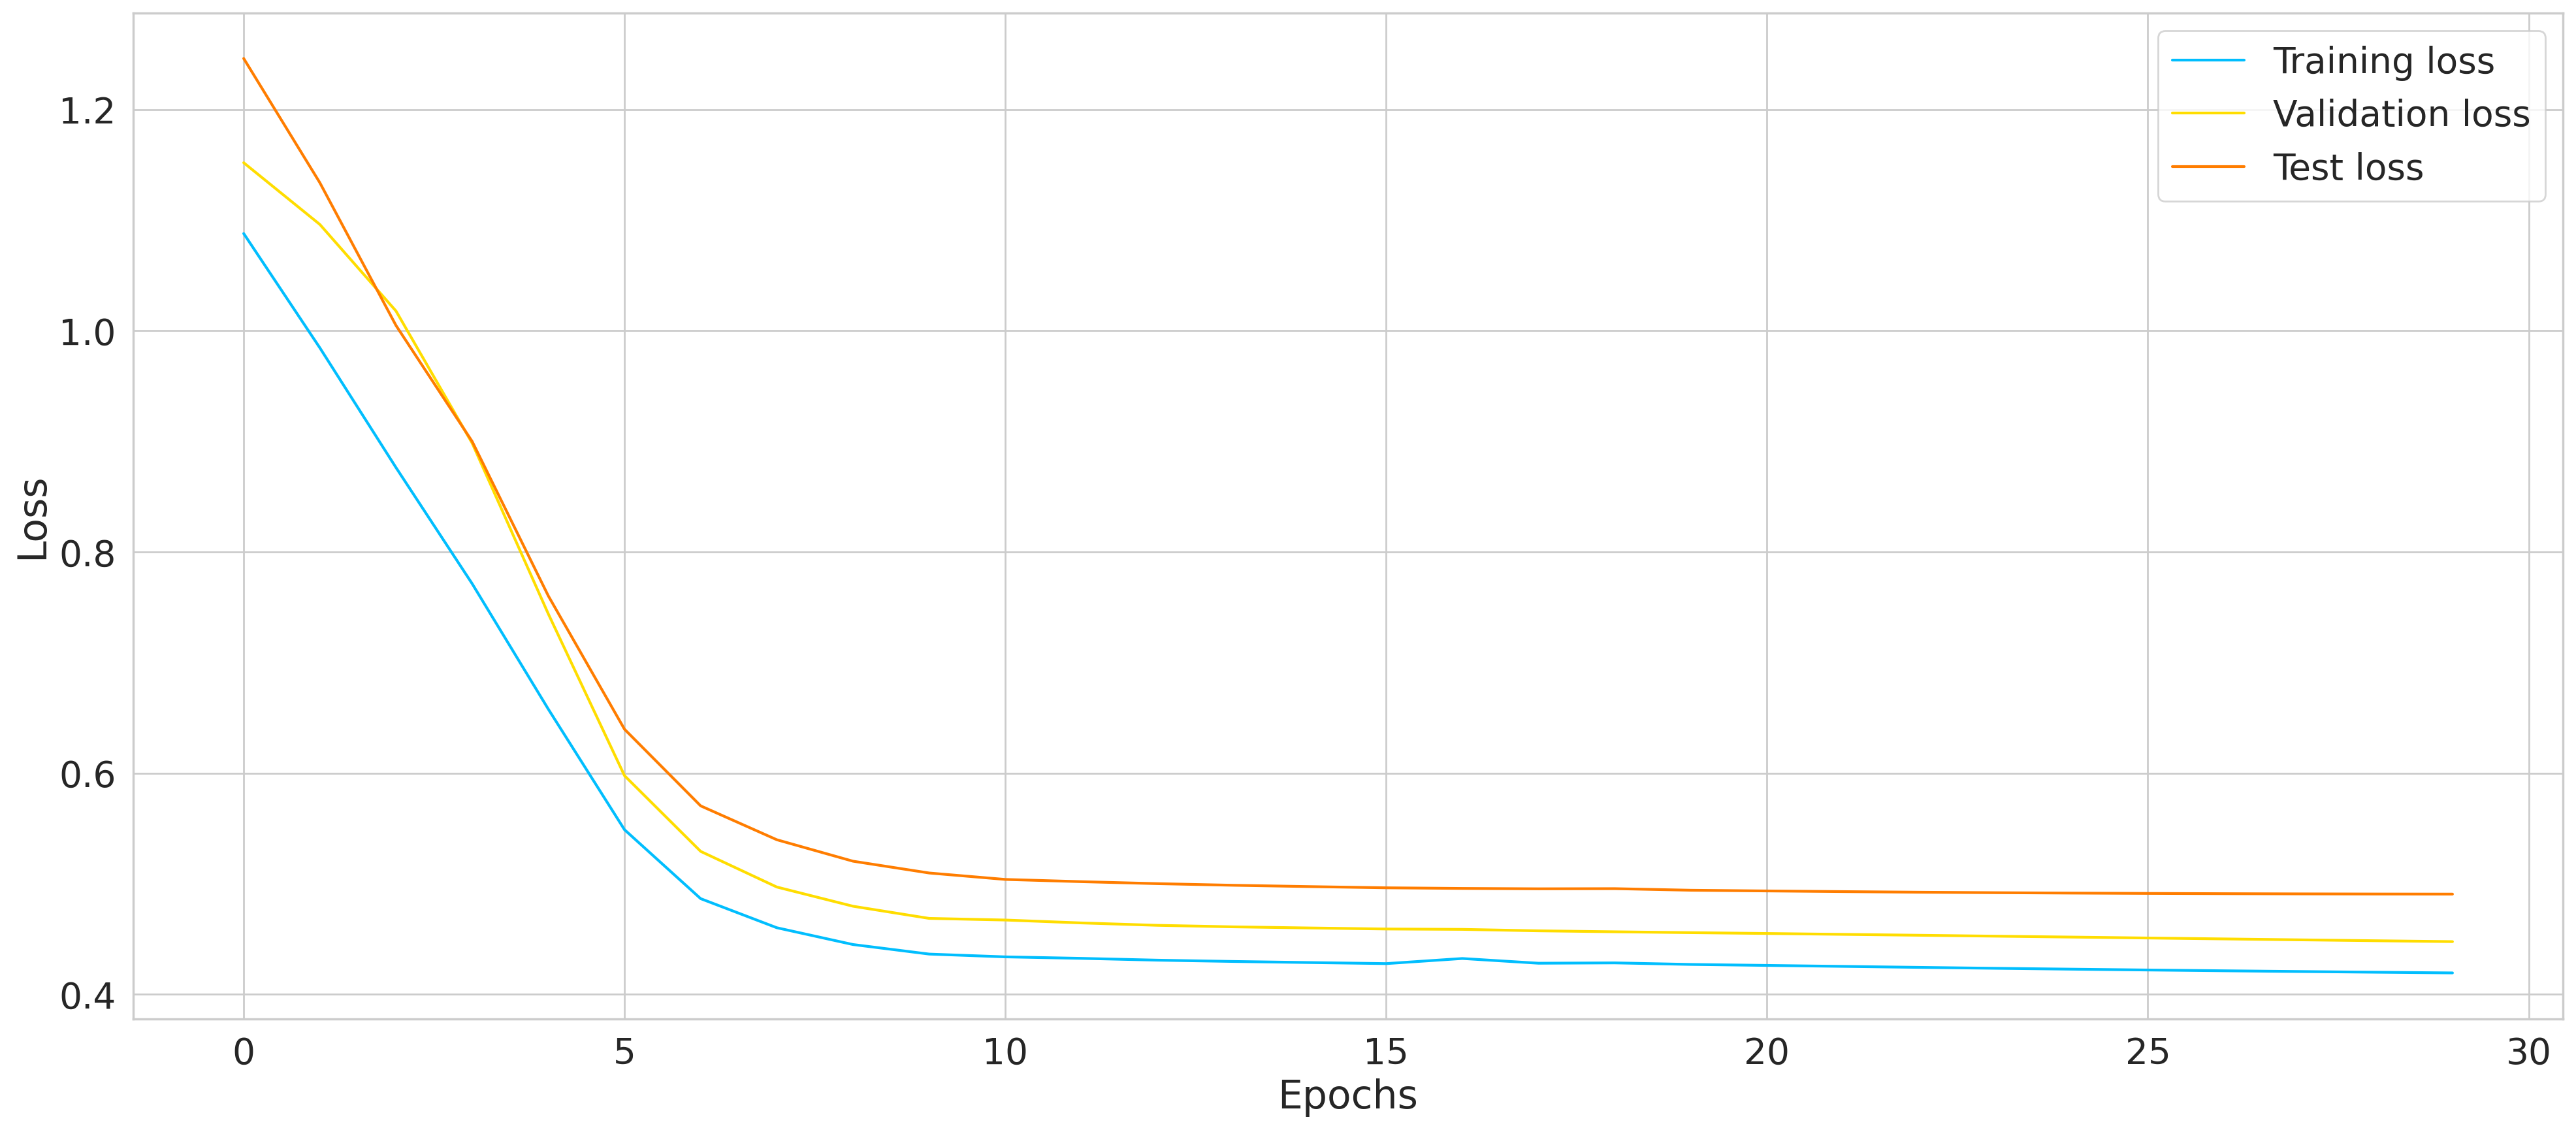

In [27]:

count_constraint_violation = []
batch_size = 128
lr = 0.001
n_hidden = 10
n_layers = 2
num_epochs = 30
boundary_tolerance = 0.1
train_history = [0] * num_epochs
validation_history = [0] * num_epochs
test_history = [0] * num_epochs

model_fcn_all, mu_hat_all, sigma_hat_all, xi_hat_all, y_all, yhat_all, y_q1_all, y_q2_all = train_model_gev(lambda_ = 0.1, lambda_2=0.9, model_name = "M3_GEV", tuning=False, validation=True, X_train = X_train_max, y_train = y_train_max)
plot_losses(train_history, validation_history, test_history)
calculate_nll(y_test_max, mu_hat_all, sigma_hat_all, xi_hat_all, name = "Model M3 Estimation (y)")
# calculate_nll(yhat_all, mu, sigma, xi_all)


PICP:  0.92578125
Correlation between actual and Predicted (mean):  0.9031570329264718
RMSE of y (standardized):  0.4668560028076172
RMSE of y :  12.941485120662342


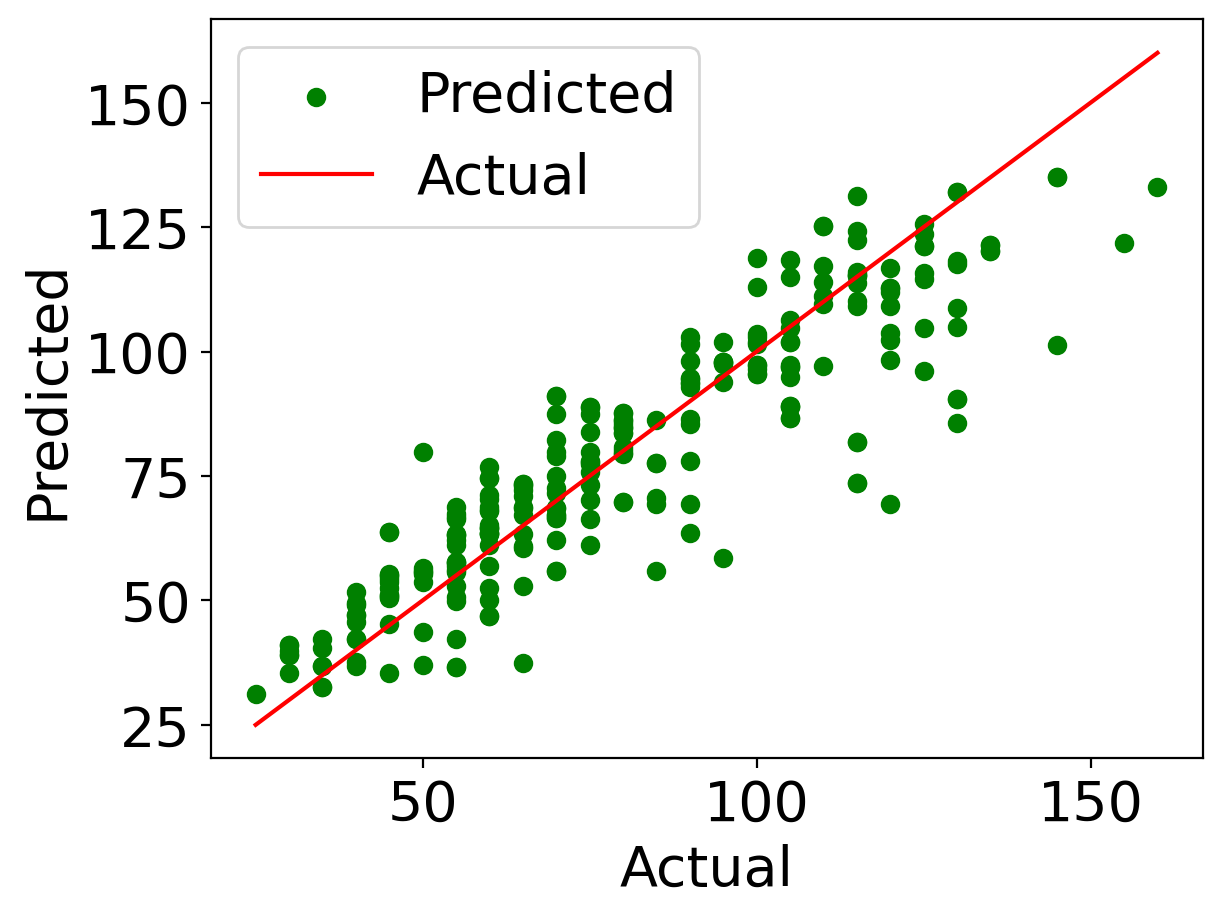

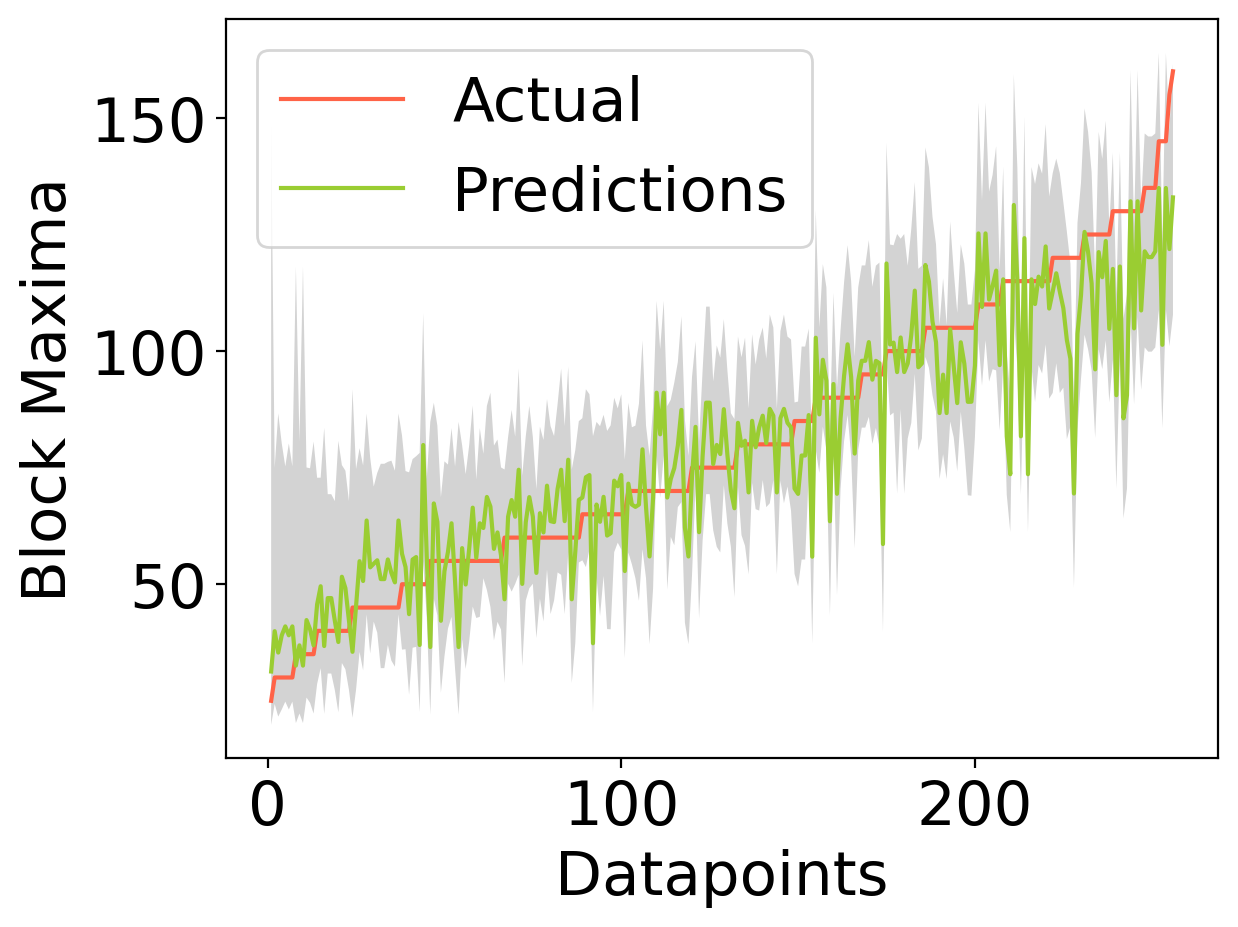

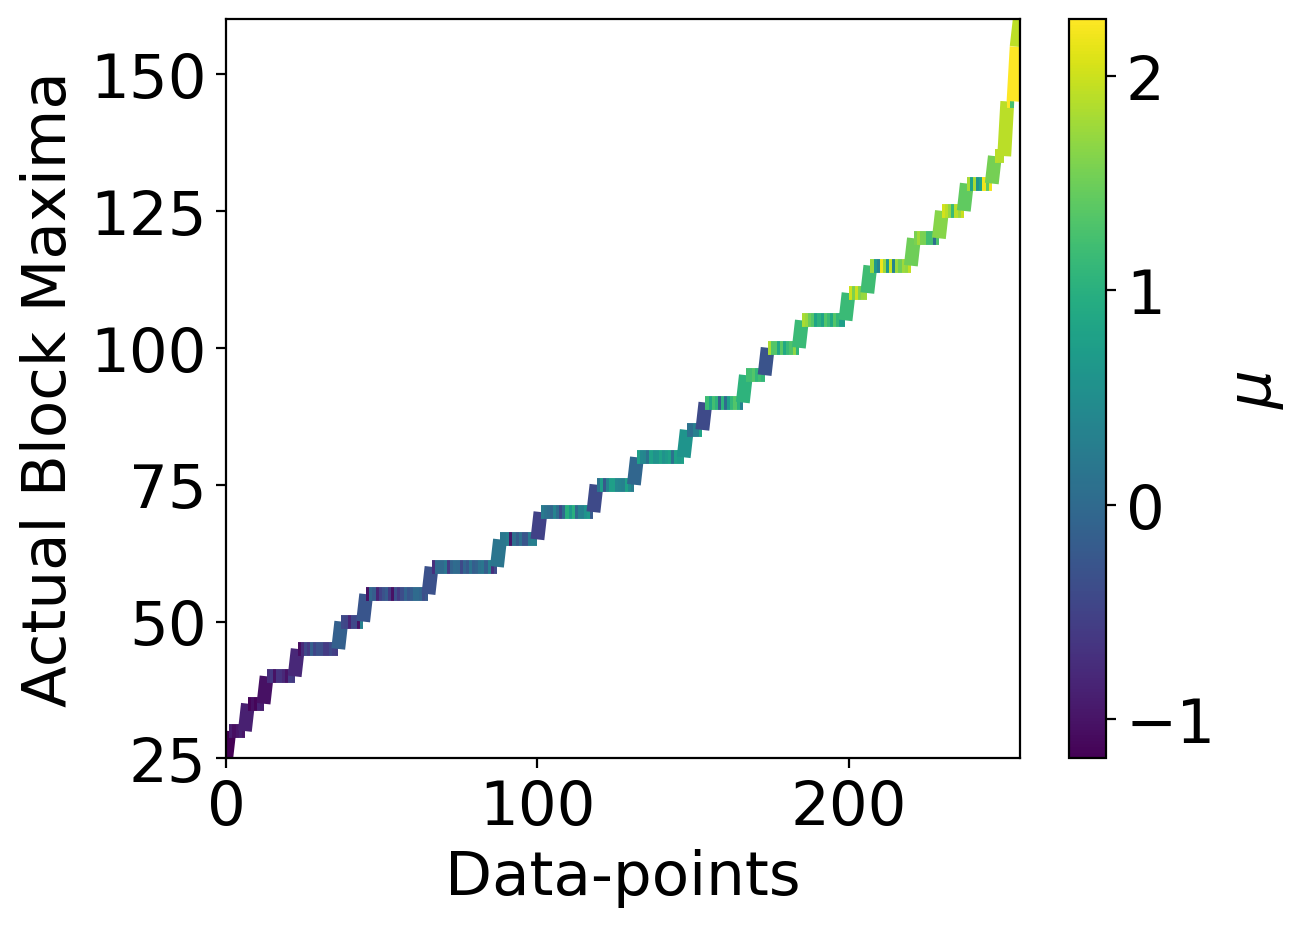

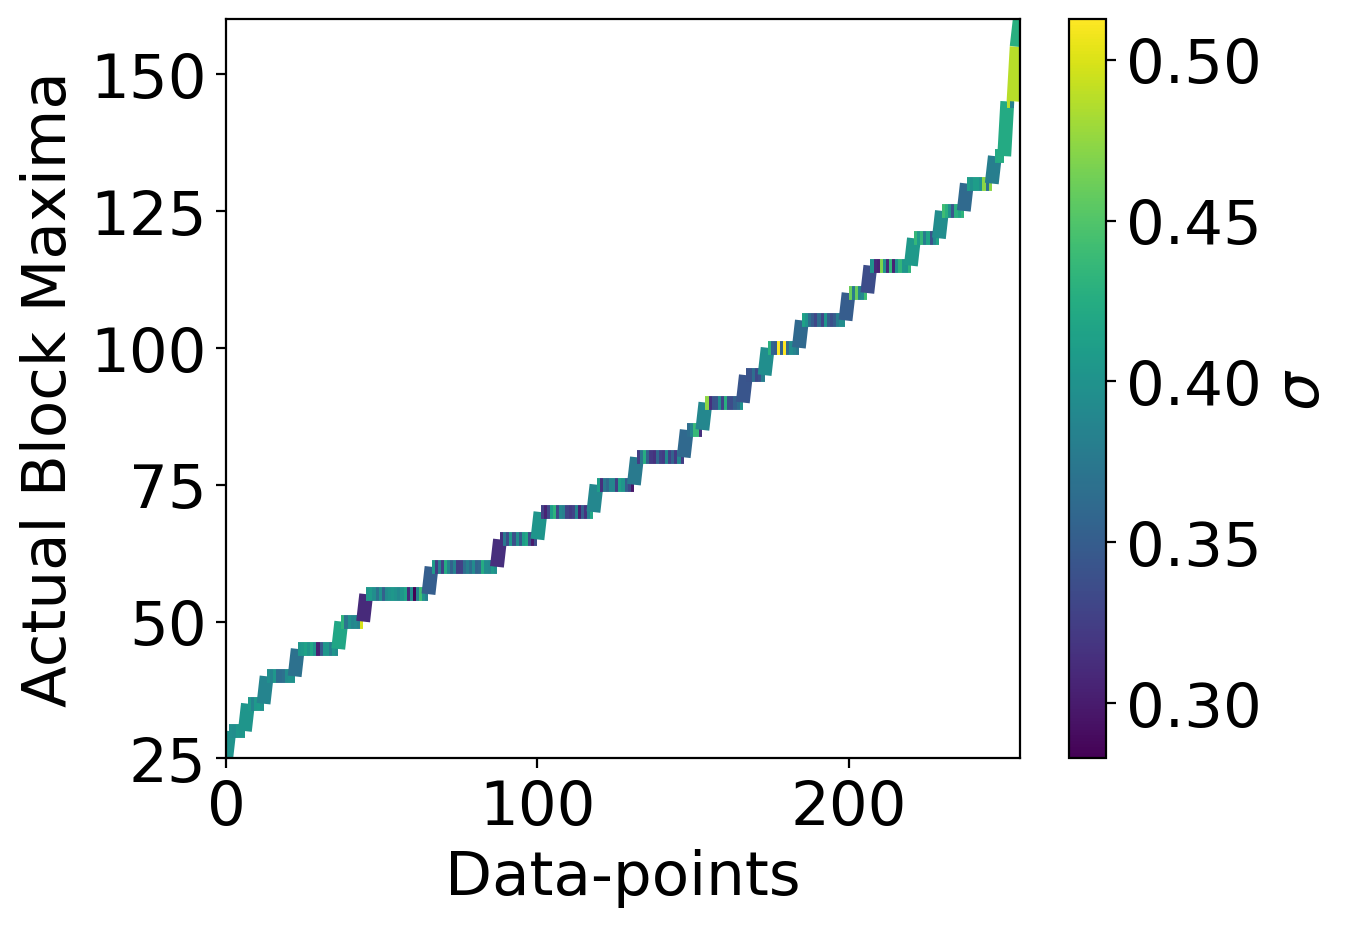

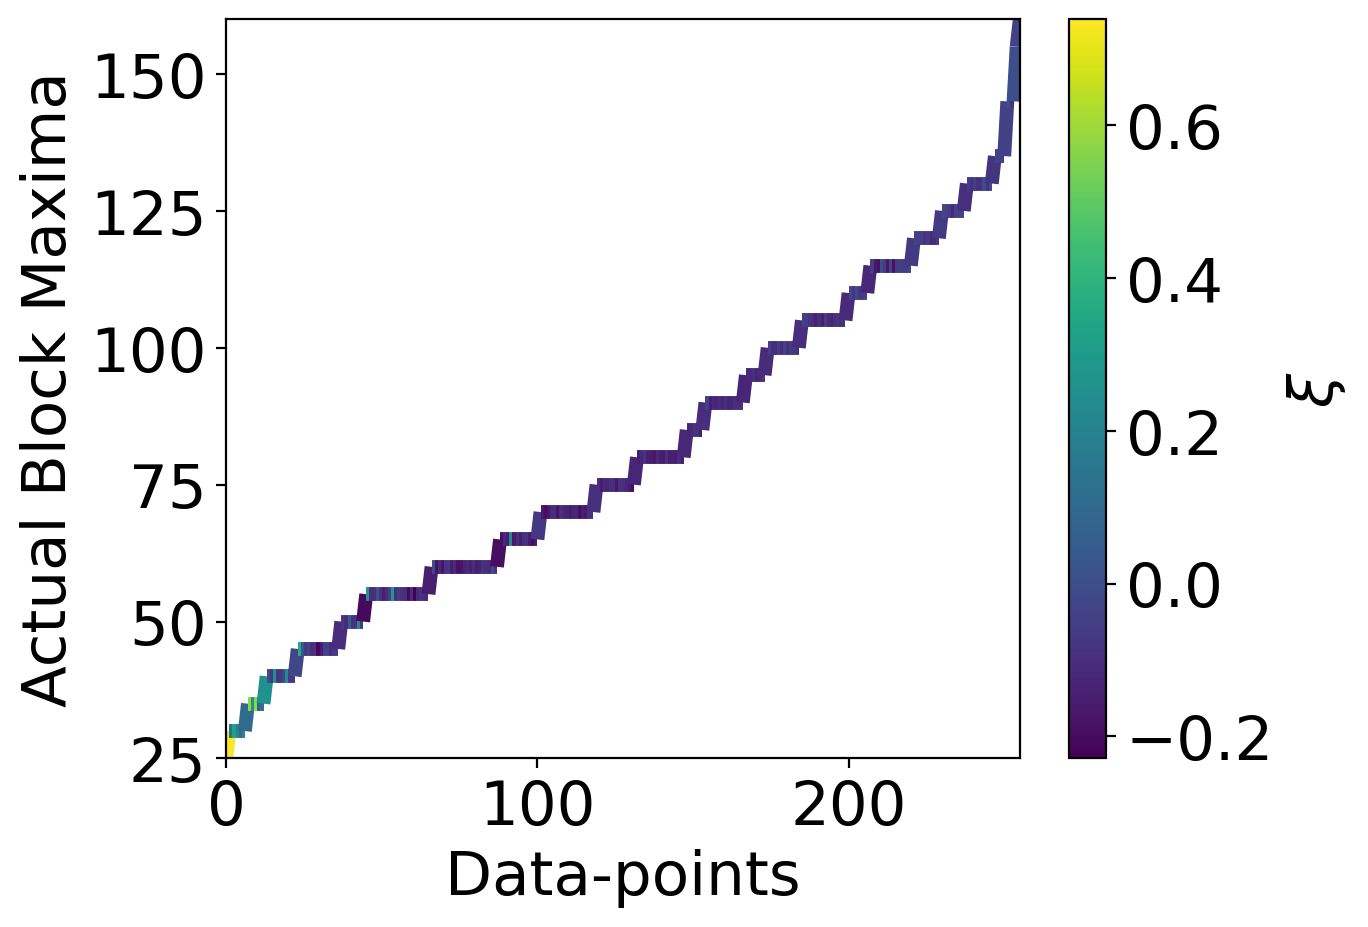

In [28]:
all_result(y_all.cpu(), yhat_all.cpu(), y_q1_all.cpu(), y_q2_all.cpu(), mu_hat_all.cpu(), sigma_hat_all.cpu(), xi_hat_all.cpu(), model_name="M3_l1=0.5_l2=0.9,hidden=10,layer=2, epochs=30")